SOR Complete -- Creating Animation


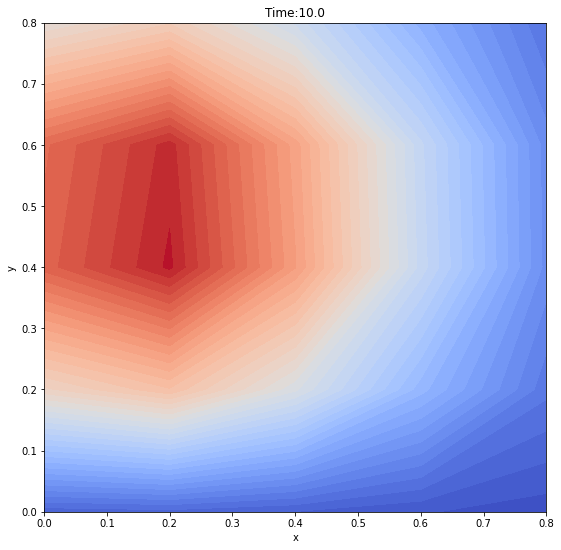

In [1]:
import math
import time
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib import cm

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=np.inf)
pd.set_option('display.max_rows',None)
plt.rcParams["animation.html"] = "jshtml"

#######################################################################################

def SOR(A, b ,w, convergence):
    
#     tic = time.time()

    #Defining critical values    
    xnew = b
    residual = np.linalg.norm(np.matmul(A, xnew) - b)
    itera = 0 #iteration counter
    backstop = 100 #end program after "" iterations
    data = []
    
    while residual > convergence:
        
        xprev = xnew[:] #xprev takes on the previous x values each iteration

        for i in range(n):
            
            sigma = 0 #reset sigma every iteration
            
            for j in range(n):
                
                #Create exception diagonal elements
                if j != i:
                        
                   #Summing the upper and lower matrix triangles togther 
                    sigma += (A[i,j] * xprev[j])
     
            #Main Equation for SOR
            xnew[i] = + (1-w)*xprev[i]+((w/A[i,i]) * (b[i] - sigma)) 
            xnorm = np.linalg.norm(xnew)
            
        #Calculating residual value
        residual = (np.linalg.norm(np.matmul(A, xnew) - b))
#         toc = time.time() - tic
    
        #Appending Data into Individual Lists at end of each loop
        data.append([n,w,itera, residual, xnorm])
        
        #Iteration Counter
        itera += 1
        
        #Prevent program running infinitely
        if itera > backstop: 
            df_residual = pd.DataFrame(data, columns=['Size','Omega','Iteration','Residual','Norm'])
            break
        
    #Output
    df_residual = pd.DataFrame(data, columns=['Size','Omega','Iteration','Residual','Norm'])
    x = np.linalg.norm(xnew)
    
    #Reset data vector in SOR Function on each pass
    data=[] 
    return xnew


#######################################################################################

#SOR adjustments
w = 1.3               #Relaxation factor 
convergence = 0.001   #Convergence critiera

#Initialise Constants
dx = 0.2        # Grid spacing in x-direction
dy = dx         # Grid Spacing in y-direction
lx = 1          # Length of plate in x-dir
ly = lx         # Length of plate in y-dir
n = int(lx/dx)  # Horizontal Grid Space Steps
m = int(ly/dy)  # Verticle Grid Space Steps
nm = int(n*m)   # Size of A matrix after subdivisions
dt = 0.1        # Time Steps
u = 0.1         #Convection velocity

#Initialise Ai Matrix and thermal coefficients
alpha = 0.05
beta = alpha
ap = dt*((1/dt)+(2*alpha/dx**2)+(2*beta/dy**2)) #Ti,j 
ae = dt*(-u/dx - alpha/(dx**2))                 #Ti+1,j 
aw = dt*(u/dx - alpha/(dx**2))                  #Ti-1,j 
an = dt*(-beta/(dy**2))                         #Ti,j+1 
aso = dt*(-beta/(dy**2))                        #Ti,j-1 

#######################################################################################

#Initialize A Matrix and then insert Boundary Conditions
#Edges = Dirichlet condition
#Central Plate = Neumman Condition
Ai = np.zeros((nm,nm), dtype=float) #Defining Dimensions of A Array

#Top Left Corner BC
Ai[0,0] = ap
Ai[0,1] = ae
Ai[0,n] = an
#Dirichlet condition dT/dy = 0, y=0, therefore aso = 0
#Dirichlet condition dT/dx = 0, x=0, therefore aw = 0

#Top Right Corner BC
Ai[(n-1),(n-1)] = ap
Ai[(n-1),(n-1)-1] = aw
Ai[(n-1),(n-1)+n] = an
#Dirichlet condition dT/dy = 0, y=0, therefore aso = 0
#Dirichlet condition dT/dx = 0, x=2, therefore ae = 0

#Bottom Left Corner BC
Ai[((m-1)*n),((m-1)*n)] = ap
Ai[((m-1)*n),((m-1)*n)+1] = ae
Ai[((m-1)*n),((m-1)*n)-n] = aso
#Dirichlet condition dT/dy = 0, y=1, therefore an = 0
#Dirichlet condition dT/dx = 0, x=0, therefore aw = 0

#Bottom Right Corner BC
Ai[(m*n-1),(m*n-1)] = ap
Ai[(m*n-1),(m*n-1)-1]  = aw
Ai[(m*n-1),(m*n-1)-n]  = aso
#Dirichlet condition dT/dy = 0, y=1, therefore an = 0
#Dirichlet condition dT/dx = 0, x=2, therefore ae = 0

#Top Side BC's
for i in range(1,n-1):
    k = i
    Ai[k,k] = ap
    Ai[k,k-1] = aw
    Ai[k,k+1] = ae
    Ai[k,k+n] = an
    #Dirichlet condition dT/dy = 0, y=0, therefore aso = 0

#Bottom side BC'c
for i in range(1,n-1):
    k = n*(m-1)+ i
    Ai[k,k] = ap
    Ai[k,k-1] = aw
    Ai[k,k+1] = ae
    Ai[k,k-n] = aso
    #Dirichlet condition dT/dy = 0, y=1, therefore an = 0

#Left Side BC's
for j in range(1,m-1):
    k = n*j 
    Ai[k,k] = ap
    Ai[k,k+1] = ae
    Ai[k,k-n] = aso
    Ai[k,k+n] = an

#Right side BC's
for j in range(2,m):
    k = n*j-1
    Ai[k,k] = ap
    Ai[k,k-1] = aw
    Ai[k,k+n] = an
    Ai[k,k-n] = aso

#Central nodes - double loop to avoid side indicies
for i in range(1,n-1):
    for j in range(1,m-1):
        k = n*i + j
#         print(k)
        Ai[k,k] = ap
        Ai[k,k-1] = aw
        Ai[k,k+1] = ae
        Ai[k,k+n] = an
        Ai[k,k-n] = aso

file1 = open("AMatrix.txt","w")
file1.write(str(Ai))
file1.close()
#######################################################################################        
        
#Initialise Temperature Vector and Time Step Vector
b = np.zeros((n*m), dtype=float)                #Initial b vector
bf = np.zeros((n*m), dtype=float)               #Final b vector
T_storage = b                                     #Storage vector for temperature after each time step
t_vect = np.arange(0,10,dt, dtype=float)         #Timestep vector
A = Ai

#2D Meshgrid for plotting temperatures along plate
xstep = np.arange(0,lx,dx)
ystep = np.arange(0,ly,dy)
xx , yy = np.meshgrid(xstep,ystep)

#Intialise figure to animate temperature changes in contourf plot
fig, ax = plt.subplots(figsize = (9,9))

#######################################################################################

#Perform SOR for all time steps in this time domain
for t in range(len(t_vect)):
    
    #Plug last solution into SOR solver
    b = bf                  
    
    #Heat applied to side of the plate
    for j in range(1,n-1):
        k = n*j+n             #Retrieve Indexing of all the side nodes
        time = t_vect[t]    #Retrieve Indexed Timestep
        
        #Heat input as function of sine: 
        if time <= 2:
            b[k] = b[k] + 20*math.sin(math.pi*time/2) #0<t<=2
            
    #SOR Function to solve HT Equations: Ax = b (finding x)
    x = SOR(A, b ,w, convergence)
    bf = np.matmul(np.linalg.inv(Ai),x) #Solution

    #Storing Temperature Data at each Timestep in single array
    T_storage = np.vstack((bf,T_storage))
    
print("SOR Complete -- Creating Animation")
file2 = open("T_storage.txt","w")
file2.write(str(T_storage))
file2.close()


#######################################################################################   

#Function to reset formatting after each frame
def init_func():
    ax.clear()
    plt.xlabel('x')
    plt.ylabel('y')
#     fig.colorbar(cm.ScalarMappable(cmap='coolwarm'), ax=ax)
#     plt.clim(0,100)
    
#Function to animate plot with new after each frame
def update_plot(i):
    T_grid = np.reshape(T_storage[len(t_vect)-i,:],(n,m))
    ax.contourf(xx,yy,T_grid, 50, cmap='coolwarm')
    title_str = "Time:" + str('%s' % float('%.1g' % t_vect[i]))                                 
    plt.title(title_str)

#Creating Animation
anim = animation.FuncAnimation(fig,update_plot,frames = len(t_vect), init_func = init_func)        

#Writing animation to gif file
f = f"{sys.path[0]}/2D_HT.gif" 
writergif = animation.PillowWriter(fps=10) 
anim.save(f, writer=writergif)

